In [26]:
# process:
# 1. get input file, 
# 2. run the model: run either gitt, C/2, or ageing, 
# for ageing, only fit soh but check many else
# for short cycle only fit voltage
# 3. post-processing
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import csv, random, os,sys
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
########################     Global settings!!!
########################     Global settings!!!
On_HPC = False 
rows_per_file = 3;  Scan_end_end = 6;
purpose_i = "Redo_GoodFitExp5_40degC_New"

if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify

Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

if On_HPC:                          # Run on HPC
    Path_csv = f"Get_Sweep/{purpose_i}/" 
    Path_Data_pre = "Example_Expdata/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else: 
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_Data_pre = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/HPC_Paper/Example_Expdata") # for experiment data
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/HPC_Paper")
    Para_file = BasicPath+  f'/Get_Sweep/{purpose_i}/'  +para_csv # for input modelling data

from Fun_P2 import *

In [28]:
parameter_names, combinations = load_combinations_from_csv(Para_file)
pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

# try to plot experiment data
Path_Data  = Path_Data_pre+"/example_Age_SOH.csv"
my_data = pd.read_csv( Path_Data)

cap_thr   = my_data["Charge Throughput (A.h)"] / 1e3
cap_C_10  = my_data["C/10 Capacity (mA.h)"]/1e3
soh_C_10  = cap_C_10 / cap_C_10[0] * 100
# plt.plot(cap_thr,soh_C_10,"-o")
cap_thr   = np.array(cap_thr).tolist()
cap_C_10  = np.array(cap_C_10).tolist()
soh_C_10  = np.array(soh_C_10).tolist()
XY_Exp =[cap_thr,soh_C_10]

#####################################################################
########################  Define experiment  ########################
#####################################################################
V_max = 4.2;        V_min = 2.5; 
exp_AGE_text = [(
    f"Discharge at 1C until {V_min}V", 
    f"Charge at 0.3C until {V_max}V",
    f"Hold at {V_max} V until C/100",
    ),  ]  # *  78
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;
exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours",

    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
cycle_no = -1; 




Total scan case is 3


In [29]:
#####################################################################
########################  Output  ###################################
#####################################################################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Y or N",
    "Error %","Punish",
    "Dry out",]

head_pos = [ 
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
if not os.path.exists(BasicPath +Target):
    os.mkdir(BasicPath +Target);
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack =[
    exp_AGE_text,exp_RPT_text,
    step_AGE_CD,step_AGE_CC,step_AGE_CV,
    step_0p1C_CD ,step_0p1C_CC,step_0p1C_RE,
    cycle_no,book_name_xlsx,
    ] 
if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [30]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  flag_RunOneCyc = False
Return_Sol=True;   Check_Small_Time=True;
fs = 13; dpi = 100;

my_dict_1Cyc,Sol_RPT,Sol_0,Call_1Cyc = Run_model (
    Para_dict_list[2],BasicPath, XY_Exp, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time
)

""" if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_model, 
        args=(
            Para_dict_i,BasicPath, XY_Exp, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time
        ) )
        for Para_dict_i in Para_dict_list]
    Result = [p.get() for p in processes]  

for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2])  """

Your own print statement
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Your own print statement
Start Now! Scan 3.
Start Now! Scan 3.
Start Now! Scan 3.
Start Now! Scan 3.
Start Now! Scan 3.
Start Now! Scan 3.
Scan 3: DryOut = On
Scan 3: DryOut = On
Scan 3: DryOut = On
Scan 3: DryOut = On
Scan 3: DryOut = On


Scan 3: DryOut = On
Scan 3: Spent 41.717 ms on Initialization
Scan 3: Spent 41.717 ms on Initialization
Scan 3: Spent 41.717 ms on Initialization
Scan 3: Spent 41.717 ms on Initialization
Scan 3: Spent 41.717 ms on Initialization
Scan 3: Spent 41.717 ms on Initialization


Initial electrolyte amount is  5.1261558457200005 mL


Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish break-in cycle within 42.954 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
Scan 3: Finish post-process for break-in cycle within 1.776 s
At t = 150.126 and h = 2.40306e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 150.127 and h = 1.73009e-12, the corrector convergence failed repeatedly or with |h| = hmin.
Scan 3: Finish for No.0 ageing cycles within 2 minutes, 51 seconds
Scan 3: Finish for No.0 ageing cycles within 2 minutes, 51 seconds
Scan 3: Finish for

Successfully create a excel file


' if __name__ == "__main__":\n    pool = multiprocessing.Pool(int(pool_no))\n    processes = [\n    pool.apply_async(\n        Run_model, \n        args=(\n            Para_dict_i,BasicPath, XY_Exp, \n            purpose,    Exp_pack, keys_all,dpi,fs,\n            flag_RunOneCyc,   Plot_Exp,Timeout,Return_Sol,\n            Check_Small_Time\n        ) )\n        for Para_dict_i in Para_dict_list]\n    Result = [p.get() for p in processes]  \n\nfor result in Result:\n    midc_merge_all.append(result[0])\n    Sol_RPT_all.append(result[1])\n    Sol_AGE_all.append(result[2])  '

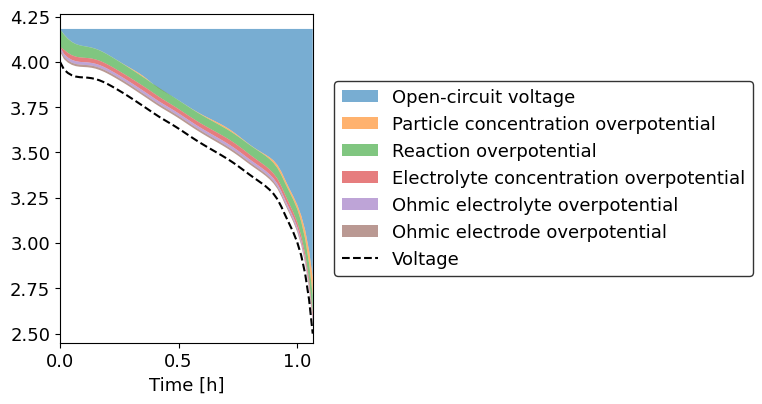

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [31]:

pb.plot_voltage_components(
    Sol_0[0].cycles[0].steps[0])

In [32]:
# Sol_0[0].cycles[-1]["Negative electrode stoichiometry"].entries
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[0].cycles[-1], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=123.21776877558382, description='t', max=128.13880219535454, min=123.2…

In [33]:
Sol_0[-2].cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [34]:
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[-1].cycles[0], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.692012724776277, step=0.046920127247762775…